In [175]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


Helper functions for preprocessing

In [176]:
def fetch_data(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional.csv"):
    response = requests.get(url)
    data = StringIO(response.text)
    df = pd.read_csv(data, sep=";")
    return df

def map_columns(df, columns, mapping):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].map(mapping)
    return df

def one_hot_encode_columns(df, columns):
    # Check if the specified columns exist in the dataframe
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {', '.join(missing_cols)}")
    
    # Apply one-hot encoding to the specified columns
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=False)

    df_encoded = df_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))
    
    return df_encoded

def encode_cyclic_information(df, column_name, mapping):
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Map the days to numbers
    df[column_name] = df[column_name].map(mapping)
    
    # Create sine and cosine features for cyclic encoding
    df[column_name + '_sin'] = np.sin(2 * np.pi * df[column_name] / 7)
    df[column_name + '_cos'] = np.cos(2 * np.pi * df[column_name] / 7)
    
    # Drop the original day column if you no longer need it
    df = df.drop(columns=[column_name])
    
    return df

def mask_column(df, column, mask_value):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    
    mask_column_name = f"{column}_unknown"
    
    # Use pd.isna to handle NaN or None
    if pd.isna(mask_value):
        df[mask_column_name] = df[column].apply(lambda x: 1 if pd.isna(x) else 0)
    else:
        df[mask_column_name] = df[column].apply(lambda x: 1 if x == mask_value else 0)
    
    return df

def replace_value_mode(df, column, mask_value):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    # Create the mask column
    if pd.isna(mask_value):
        mask = df[column].isna()
    else:
        mask = df[column] == mask_value

    # Compute the mode of the column, excluding NaN
    column_mode = df.loc[~mask, column].mode()

    if column_mode.empty:
        raise ValueError(f"Cannot compute mode for column '{column}' as it has no valid values.")

    # Replace masked values with the mode
    df[column] = df[column].where(~mask, column_mode[0])

    return df

def standardize_columns(data, columns):
    scaler = StandardScaler()
    for column in columns : 
        if column in data.columns:
            data[column] = scaler.fit_transform(data[[column]])
    return data

def drop_specific_data(data):
    #Drop the default column (20% is unknown, there are 3/41188 yes)
    #Drop the Pdays column (96.3% unknown)
    #Drop duration, as its for benchmarking not modeling (Supposedly, might want to readd this)

    data = data.drop(columns="default")
    data = data.drop(columns="pdays")
    # data = data.drop(columns="duration")

    #Drop the 5 unknown data entries for now (Might readd later to see if models get more accurate)
    # data = data.drop(columns="nr.employed")
    # data = data.drop(columns="euribor3m")
    # data = data.drop(columns="cons.conf.idx")
    # data = data.drop(columns="emp.var.rate")
    # data = data.drop(columns="cons.price.idx")
    
    return data
    


Preprocessing

In [177]:
def preprocessing(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional.csv",mask_nans = True):
    binary_mapping = {
        'yes':1,
        'no':0,
        }

    education_mapping = {
        'basic.4y':1,
        'basic.6y':2,
        'basic.9y':3,
        'high.school':4,
        'illiterate':0,
        'professional.course':5,
        'university.degree':6,
        'unknown': None
        }

    days_mapping = {
            'sun': 0,
            'mon': 1,
            'tue': 2,
            'wed': 3,
            'thu': 4,
            'fri': 5,
            'sat': 6
        }

    months_mapping = {
            'jan': 0,
            'feb': 1,
            'mar': 2,
            'apr': 3,
            'may': 4,
            'jun': 5,
            'jul': 6,
            'aug': 7,
            'sep': 8,
            'oct': 9,
            'nov': 10,
            'dec': 11
        }

    binary_columns = ["housing", "loan", "y"]
    categorical_columns = ["job","marital","contact","poutcome"]
    integer_columns = ["age", "balance", "duration", "campaign", "previous"]

    data = fetch_data(url)
    
    #Remove Duplicate rows
    data = data[~data.duplicated()]

    #Drop necissary features
    data = drop_specific_data(data)

    #Map Binary values to 0,1,NaN
    data = map_columns(data, binary_columns, binary_mapping)

    #Map education to numeric quantities
    data = map_columns(data, ["education"], education_mapping)

    #One hot encode categorical data
    data = one_hot_encode_columns(data, categorical_columns)

    #Perform Cyclical mapping for time data
    data = encode_cyclic_information(data, "day_of_week", days_mapping)
    data = encode_cyclic_information(data, "month", months_mapping)
    
    #Standardize Integer Columns
    data = standardize_columns(data, integer_columns)
    
    if mask_nans :
        #create a mask for housing, loan, education columns
        data = mask_column(data, "housing", None)
        data = mask_column(data, "loan", None)
        data = mask_column(data, "education", None)

        #Imput Housing and Loan to the mode
        data = replace_value_mode(data, "housing", None)
        data = replace_value_mode(data, "loan", None)
        data['education'] = data['education'].fillna(-1)
        
    return data

In [178]:
def get_unknown_percentage(df, dataset_name="Data"):
    unknown_percentages = {}
    unknown_columns_count = 0

    # Loop over each column in the dataframe
    for column in df.columns:
        # Count the occurrences of 'unknown' in the column
        unknown_count = (df[column] == 'unknown').sum()

        if column == "pdays":
            unknown_count += (df[column] == 999).sum()

        unknown_count += (df[column].isna()).sum()

        # Calculate the percentage of 'unknown' values
        total_count = len(df[column])
        unknown_percentage = (unknown_count / total_count) * 100

        # Store the percentage in the dictionary
        unknown_percentages[column] = unknown_percentage
        if unknown_percentage > 0:
            unknown_columns_count += 1
            print(f"{dataset_name} - {column} unknowns: {unknown_percentage}%")

    if unknown_columns_count == 0:
        print(f"{dataset_name} - No unknowns in the data.")
    return unknown_percentages

def count_values(column_name, dataframe, dataset_name="Data"):
    if column_name not in dataframe.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return None
    counts = dataframe[column_name].value_counts()
    print(f"{dataset_name} - Value counts for column '{column_name}':\n{counts}")
    return counts

def compare_unknowns_and_values(data, processed_data):
    # Compare unknown percentages in original and processed data
    print("\n--- Comparing unknown percentages in original and processed data ---\n")
    
    original_unknowns = get_unknown_percentage(data, "Original Data")
    processed_unknowns = get_unknown_percentage(processed_data, "Processed Data")
    
    # Compare unknown percentages for each column that exists in both dataframes
    for column in data.columns:
        if column in processed_data.columns:
            original_percentage = original_unknowns.get(column, 0)
            processed_percentage = processed_unknowns.get(column, 0)
            
            print(f"\nColumn: {column}")
            print(f"  Original data unknown percentage: {original_percentage}%")
            print(f"  Processed data unknown percentage: {processed_percentage}%")
            print("  Change in unknowns: {:.2f}%".format(processed_percentage - original_percentage))
        else:
            print(f"\nColumn '{column}' was dropped in the processed data.")

    # Compare value counts for each column that exists in both dataframes
    print("\n--- Comparing value counts for each column ---")
    for column in data.columns:
        if column in processed_data.columns:
            count_values(column, data, "Original Data")
            count_values(column, processed_data, "Processed Data")
        else:
            print(f"\nColumn '{column}' was dropped in the processed data.")

def compare_data():
    # Example usage
    data = fetch_data()  # Fetch original data
    processed_data = preprocessing()  # Preprocess the data

    # Compare unknowns and value counts
    compare_unknowns_and_values(data, processed_data)

compare_data()



--- Comparing unknown percentages in original and processed data ---

Original Data - job unknowns: 0.9468317552804079%
Original Data - marital unknowns: 0.2670551104637048%
Original Data - education unknowns: 4.054382131585337%
Original Data - default unknowns: 19.49502306385045%
Original Data - housing unknowns: 2.5491624180626364%
Original Data - loan unknowns: 2.5491624180626364%
Original Data - pdays unknowns: 96.11556202961884%
Processed Data - No unknowns in the data.

Column: age
  Original data unknown percentage: 0.0%
  Processed data unknown percentage: 0.0%
  Change in unknowns: 0.00%

Column 'job' was dropped in the processed data.

Column 'marital' was dropped in the processed data.

Column: education
  Original data unknown percentage: 4.054382131585337%
  Processed data unknown percentage: 0.0%
  Change in unknowns: -4.05%

Column 'default' was dropped in the processed data.

Column: housing
  Original data unknown percentage: 2.5491624180626364%
  Processed data unkno

In [ ]:
def get_X_y_data(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional.csv"):
    
    data = preprocessing(url)
    data.head()
    y = data['y']
    X = data.drop(columns=['y'])
    
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test
        
def create_under_sampled_data(X_train, y_train, under_strength = 0.1):
    under = RandomUnderSampler(sampling_strategy=under_strength, random_state=42)
    X_train_under, y_train_under = under.fit_resample(X_train, y_train)
    
    return X_train_under, y_train_under

def create_over_sampled_data(X_train, y_train, over_strength=2) :
       over = SMOTE(sampling_strategy=over_strength, random_state=42)
       X_train_over, y_train_over = over.fit_resample(X_train, y_train)
       
       return X_train_over, y_train_over


def train_and_evaluate(X_train, y_train, X_test, y_test, model, param_grid, label):
    
    pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=pr_auc_scorer,
        cv=5,
        verbose=2,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"\nBest Parameters for {label}:")
    print(grid_search.best_params_)
    
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    print(f"\nConfusion Matrix for {label}:")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score for {label}: {roc_auc:.2f}")
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC for {label}: {pr_auc:.2f}")
    
    return precision, recall, pr_auc

def class_weighting(y_train):
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    return {cls: weight for cls, weight in zip(classes, class_weights)}

Model types to make

SVM [Tucker]
Linear Regression
Logistic Regression
Gradient Boosting
Random Forest [Ryan]
Decision tree
Bagging

Most likely usefull models
Logistic Regression
Random Forest

c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters for Standard SVM:
{'C': 100, 'gamma': 0.001}

Confusion Matrix for Standard SVM:
[[713  19]
 [ 58  34]]

Classification Report for Standard SVM:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       732
           1       0.64      0.37      0.47        92

    accuracy                           0.91       824
   macro avg       0.78      0.67      0.71       824
weighted avg       0.89      0.91      0.90       824

ROC AUC Score for Standard SVM: 0.93
Precision-Recall AUC for Standard SVM: 0.57
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



Best Parameters for Oversampled SVM:
{'C': 10, 'gamma': 1}

Confusion Matrix for Oversampled SVM:
[[729   3]
 [ 91   1]]

Classification Report for Oversampled SVM:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       732
           1       0.25      0.01      0.02        92

    accuracy                           0.89       824
   macro avg       0.57      0.50      0.48       824
weighted avg       0.82      0.89      0.84       824

ROC AUC Score for Oversampled SVM: 0.85
Precision-Recall AUC for Oversampled SVM: 0.36
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



Best Parameters for Undersampled SVM:
{'C': 100, 'gamma': 0.001}

Confusion Matrix for Undersampled SVM:
[[653  79]
 [ 18  74]]

Classification Report for Undersampled SVM:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       732
           1       0.48      0.80      0.60        92

    accuracy                           0.88       824
   macro avg       0.73      0.85      0.77       824
weighted avg       0.92      0.88      0.89       824

ROC AUC Score for Undersampled SVM: 0.93
Precision-Recall AUC for Undersampled SVM: 0.55
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



Best Parameters for Standard Weighted SVM:
{'C': 10, 'gamma': 0.001}

Confusion Matrix for Standard Weighted SVM:
[[620 112]
 [ 12  80]]

Classification Report for Standard Weighted SVM:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       732
           1       0.42      0.87      0.56        92

    accuracy                           0.85       824
   macro avg       0.70      0.86      0.74       824
weighted avg       0.92      0.85      0.87       824

ROC AUC Score for Standard Weighted SVM: 0.93
Precision-Recall AUC for Standard Weighted SVM: 0.50
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



Best Parameters for Oversampled Weighted SVM:
{'C': 1, 'gamma': 1}

Confusion Matrix for Oversampled Weighted SVM:
[[729   3]
 [ 90   2]]

Classification Report for Oversampled Weighted SVM:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       732
           1       0.40      0.02      0.04        92

    accuracy                           0.89       824
   macro avg       0.65      0.51      0.49       824
weighted avg       0.84      0.89      0.84       824

ROC AUC Score for Oversampled Weighted SVM: 0.86
Precision-Recall AUC for Oversampled Weighted SVM: 0.38
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(



Best Parameters for Undersampled Weighted SVM:
{'C': 100, 'gamma': 0.001}

Confusion Matrix for Undersampled Weighted SVM:
[[619 113]
 [ 11  81]]

Classification Report for Undersampled Weighted SVM:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       732
           1       0.42      0.88      0.57        92

    accuracy                           0.85       824
   macro avg       0.70      0.86      0.74       824
weighted avg       0.92      0.85      0.87       824

ROC AUC Score for Undersampled Weighted SVM: 0.93
Precision-Recall AUC for Undersampled Weighted SVM: 0.52


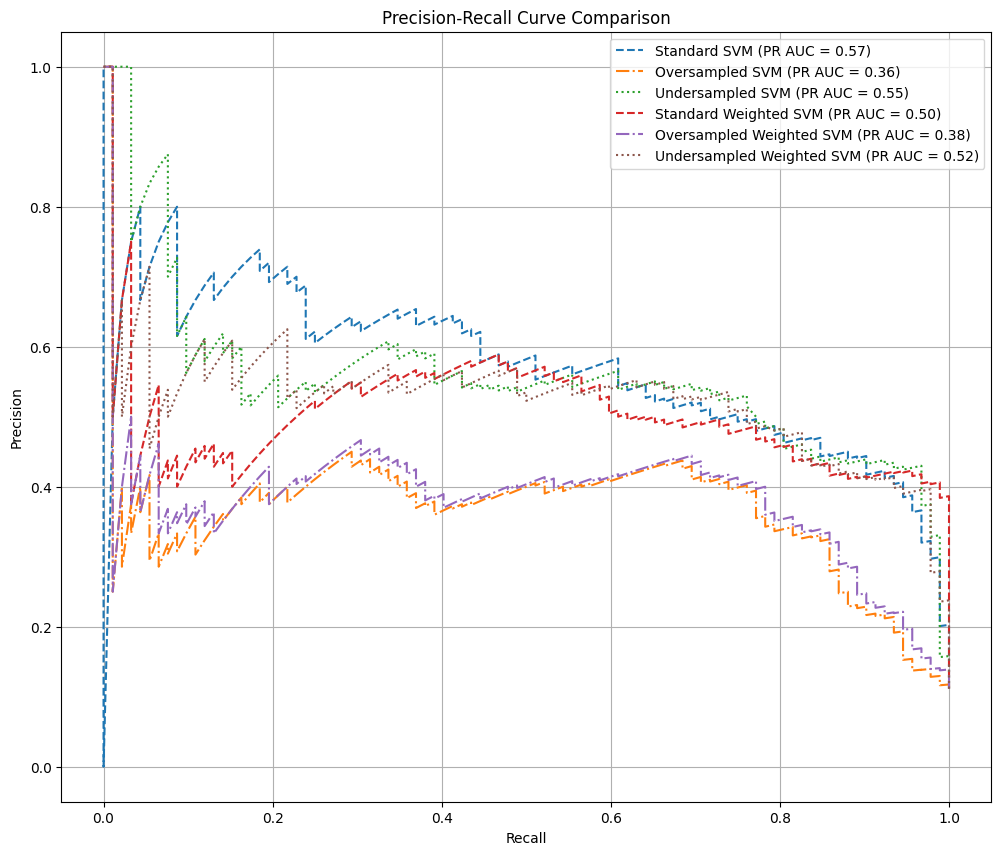

In [180]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
}  

def create_svc():
    #Get Data Samples
    X_train, y_train, X_test, y_test = get_X_y_data()
    X_train_over, y_train_over = create_over_sampled_data(X_train, y_train, over_strength=0.5)
    X_train_under, y_train_under = create_under_sampled_data(X_train, y_train)
    
    #Get class weights
    class_weights_dict_s = class_weighting(y_train)
    class_weights_dict_o = class_weighting(y_train_over)
    class_weights_dict_u = class_weighting(y_train_under)
    
    # Define the SVM models
    svm_standard = SVC(kernel='rbf', probability=True, random_state=42)
    svm_over = SVC(kernel='rbf', probability=True, random_state=42)
    svm_under = SVC(kernel='rbf', probability=True, random_state=42)
    svm_standard_weighted = SVC(kernel='rbf', class_weight=class_weights_dict_s, probability=True, random_state=42)
    svm_over_weighted = SVC(kernel='rbf', class_weight=class_weights_dict_o, probability=True, random_state=42)
    svm_under_weighted = SVC(kernel='rbf', class_weight=class_weights_dict_u, probability=True, random_state=42)

    # Train and evaluate models
    precision_std, recall_std, pr_auc_std = train_and_evaluate(X_train, y_train, X_test, y_test, svm_standard, param_grid, "Standard SVM")
    precision_over, recall_over, pr_auc_over = train_and_evaluate(X_train_over, y_train_over, X_test, y_test, svm_over, param_grid, "Oversampled SVM")
    precision_under, recall_under, pr_auc_under = train_and_evaluate(X_train_under, y_train_under, X_test, y_test, svm_under, param_grid, "Undersampled SVM")
    precision_std_w, recall_std_w, pr_auc_std_w = train_and_evaluate(X_train, y_train, X_test, y_test, svm_standard_weighted, param_grid, "Standard Weighted SVM")
    precision_over_w, recall_over_w, pr_auc_over_w = train_and_evaluate(X_train_over, y_train_over, X_test, y_test, svm_over_weighted, param_grid, "Oversampled Weighted SVM")
    precision_under_w, recall_under_w, pr_auc_under_w = train_and_evaluate(X_train_under, y_train_under, X_test, y_test, svm_under_weighted, param_grid, "Undersampled Weighted SVM")

    # Plot Precision-Recall curves for comparison
    plt.figure(figsize=(12, 10))
    plt.plot(recall_std, precision_std, label=f"Standard SVM (PR AUC = {pr_auc_std:.2f})", linestyle='--')
    plt.plot(recall_over, precision_over, label=f"Oversampled SVM (PR AUC = {pr_auc_over:.2f})", linestyle='-.')
    plt.plot(recall_under, precision_under, label=f"Undersampled SVM (PR AUC = {pr_auc_under:.2f})", linestyle=':')
    plt.plot(recall_std_w, precision_std_w, label=f"Standard Weighted SVM (PR AUC = {pr_auc_std_w:.2f})", linestyle='--')
    plt.plot(recall_over_w, precision_over_w, label=f"Oversampled Weighted SVM (PR AUC = {pr_auc_over_w:.2f})", linestyle='-.')
    plt.plot(recall_under_w, precision_under_w, label=f"Undersampled Weighted SVM (PR AUC = {pr_auc_under_w:.2f})", linestyle=':')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend()
    plt.grid()
    plt.show()
    
create_svc()

In [181]:
def create_logistic_regression():
    # Get class weights
    scaler = StandardScaler
    X_scaled = scaler.fit_transform(X_train)
    class_weights_dict_s = class_weighting(y_train)
    class_weights_dict_o = class_weighting(y_train_over)
    class_weights_dict_u = class_weighting(y_train_under)
    
    # Define the Logistic Regression models
    lr_standard = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
    lr_over = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
    lr_under = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
    lr_standard_weighted = LogisticRegression(solver='lbfgs', class_weight=class_weights_dict_s, max_iter=1000, random_state=42)
    lr_over_weighted = LogisticRegression(solver='lbfgs', class_weight=class_weights_dict_o, max_iter=1000, random_state=42)
    lr_under_weighted = LogisticRegression(solver='lbfgs', class_weight=class_weights_dict_u, max_iter=1000, random_state=42)

    # Define parameter grid for GridSearchCV
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }

    # Train and evaluate models
    precision_std, recall_std, pr_auc_std = train_and_evaluate(X_train, y_train, X_test, y_test, lr_standard, param_grid, "Standard Logistic Regression")
    precision_over, recall_over, pr_auc_over = train_and_evaluate(X_train_over, y_train_over, X_test, y_test, lr_over, param_grid, "Oversampled Logistic Regression")
    precision_under, recall_under, pr_auc_under = train_and_evaluate(X_train_under, y_train_under, X_test, y_test, lr_under, param_grid, "Undersampled Logistic Regression")
    precision_std_w, recall_std_w, pr_auc_std_w = train_and_evaluate(X_train, y_train, X_test, y_test, lr_standard_weighted, param_grid, "Standard Weighted Logistic Regression")
    precision_over_w, recall_over_w, pr_auc_over_w = train_and_evaluate(X_train_over, y_train_over, X_test, y_test, lr_over_weighted, param_grid, "Oversampled Weighted Logistic Regression")
    precision_under_w, recall_under_w, pr_auc_under_w = train_and_evaluate(X_train_under, y_train_under, X_test, y_test, lr_under_weighted, param_grid, "Undersampled Weighted Logistic Regression")

    # Plot Precision-Recall curves for comparison
    plt.figure(figsize=(12, 10))
    plt.plot(recall_std, precision_std, label=f"Standard Logistic Regression (PR AUC = {pr_auc_std:.2f})", linestyle='--')
    plt.plot(recall_over, precision_over, label=f"Oversampled Logistic Regression (PR AUC = {pr_auc_over:.2f})", linestyle='-.')
    plt.plot(recall_under, precision_under, label=f"Undersampled Logistic Regression (PR AUC = {pr_auc_under:.2f})", linestyle=':')
    plt.plot(recall_std_w, precision_std_w, label=f"Standard Weighted Logistic Regression (PR AUC = {pr_auc_std_w:.2f})", linestyle='--')
    plt.plot(recall_over_w, precision_over_w, label=f"Oversampled Weighted Logistic Regression (PR AUC = {pr_auc_over_w:.2f})", linestyle='-.')
    plt.plot(recall_under_w, precision_under_w, label=f"Undersampled Weighted Logistic Regression (PR AUC = {pr_auc_under_w:.2f})", linestyle=':')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend()
    plt.grid()
    plt.show()

create_logistic_regression()


TypeError: TransformerMixin.fit_transform() missing 1 required positional argument: 'X'